In [1]:
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# %%
# ─── Check GPU ───────────────────────────────────────────────────────────────
print(f"PyTorch : {torch.__version__}")
print(f"CUDA    : {torch.cuda.is_available()}")
print(f"GPU     : {torch.cuda.get_device_name(0)}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# %%
# ─── Peek at the dataset ─────────────────────────────────────────────────────
with h5py.File("Dataset_Specific_Unlabelled.h5", "r") as f:
    for key in f.keys():
        print(key, f[key].shape)

# %%

PyTorch : 2.12.0.dev20260217+cu128
CUDA    : True
GPU     : NVIDIA GeForce RTX 5060 Laptop GPU
jet (60000, 125, 125, 8)


In [2]:
class H5Dataset(Dataset):
    def __init__(self, file_path, x_key="jet", threshold=0.0):
        self.file      = h5py.File(file_path, "r")
        self.X         = self.file[x_key]
        self.threshold = threshold

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x    = torch.tensor(self.X[idx], dtype=torch.float32)  # (H, W, C)
        x    = x.permute(2, 0, 1)                              # (C, H, W)
        mask = (x.abs().sum(dim=0, keepdim=True) > self.threshold)  # (1, H, W)
        return x, mask


def count_active_sites(mask):
    """Count active sites per layer — paper tracks this in Tables 2-4"""
    return mask.sum().item()

# In forward pass, track per layer:
def forward(self, x, mask):
    active_counts = {}

    z, m = self.enc1(x, mask);  z = self.relu(z)
    active_counts['enc1'] = count_active_sites(m)

    z, m = self.enc2(z, m);     z = self.relu(z)
    active_counts['enc2'] = count_active_sites(m)

    z, m = self.down1(z, m);    z = self.relu(z)
    active_counts['down1'] = count_active_sites(m)

    z, m = self.enc3(z, m);     z = self.relu(z)
    active_counts['enc3'] = count_active_sites(m)

    z, m = self.down2(z, m);    z = self.relu(z)
    active_counts['down2'] = count_active_sites(m)

    ...
    return x_hat, latent, active_counts

class SubmanifoldSparseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        padding   = kernel_size // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              padding=padding, bias=True)   # allow bias
        self.bn   = nn.BatchNorm2d(out_channels)

    def forward(self, x, mask):
        # Compute ground state once (what zero input produces)
        ground_state = self.bn(self.conv(torch.zeros_like(x[:1])))

        # Zero inactive sites, apply conv
        x   = x * mask.float()
        out = self.bn(self.conv(x))

        # Subtract ground state at inactive sites, zero them out
        out = out - ground_state                # center around ground state
        out = out * mask.float()               # zero inactive sites
        return out, mask


class StridedSparseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2):
        super().__init__()
        padding     = kernel_size // 2
        self.conv   = nn.Conv2d(in_channels, out_channels, kernel_size,
                                stride=stride, padding=padding, bias=False)
        self.bn     = nn.BatchNorm2d(out_channels)
        self.stride = stride

    def forward(self, x, mask):
        x   = x * mask.float()
        out = self.bn(self.conv(x))

        # match mask size to conv output size exactly
        out_h, out_w = out.shape[2], out.shape[3]
        new_mask = F.adaptive_max_pool2d(mask.float(), (out_h, out_w)) > 0

        out = out * new_mask.float()
        return out, new_mask


In [3]:
class SparseAutoencoder(nn.Module):
    def __init__(self, in_channels=8):  # only in_channels, no out_channels
        super().__init__()

        # Encoder
        self.enc1  = SubmanifoldSparseConv2d(in_channels, 32,  3)
        self.enc2  = SubmanifoldSparseConv2d(32,          64,  3)
        self.down1 = StridedSparseConv2d    (64,          64,  3, stride=2)
        self.enc3  = SubmanifoldSparseConv2d(64,          128, 3)
        self.down2 = StridedSparseConv2d    (128,         128, 3, stride=2)

        # Decoder
        self.up1   = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.dec1  = SubmanifoldSparseConv2d(64,  64,          3)
        self.up2   = nn.ConvTranspose2d(64,  32, 3, stride=2, padding=1, output_padding=1)
        self.dec2  = SubmanifoldSparseConv2d(32,  in_channels, 3)

        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x, mask):
        H, W = x.shape[2], x.shape[3]

        # Encoder
        z, m  = self.enc1(x, mask);  z = self.relu(z)
        z, m  = self.enc2(z, m);     z = self.relu(z)
        z, m  = self.down1(z, m);    z = self.relu(z)
        z, m  = self.enc3(z, m);     z = self.relu(z)
        z, m  = self.down2(z, m);    z = self.relu(z)

        latent = z

        # Decoder
        z     = self.relu(self.up1(z))
        m_up1 = F.interpolate(m.float(), scale_factor=2, mode='nearest') > 0
        z, _  = self.dec1(z, m_up1);  z = self.relu(z)

        z     = self.relu(self.up2(z))
        m_up2 = F.interpolate(m_up1.float(), scale_factor=2, mode='nearest') > 0
        x_hat, _ = self.dec2(z, m_up2)

        x_hat = x_hat[:, :, :H, :W]

        return x_hat, latent



In [4]:
def sparse_loss(x, x_hat, latent, mask, l1_lambda=3e-4):
    # Reconstruction loss computed ONLY at active sites
    active      = mask.expand_as(x)
    recon_loss  = F.mse_loss(x_hat[active], x[active])

    # L1 sparsity on latent
    sparsity    = torch.mean(torch.abs(latent))

    return recon_loss + l1_lambda * sparsity, recon_loss, sparsity

dataset   = H5Dataset("Dataset_Specific_Unlabelled.h5", x_key="jet")
loader    = DataLoader(dataset, batch_size=100, shuffle=True,
                       num_workers=0, pin_memory=True)

model     = SparseAutoencoder(in_channels=8).to(device)
#model     = torch.compile(model) 

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

print(f"\nDataset size : {len(dataset)}")
print(f"Batches/epoch: {len(loader)}\n")

for epoch in range(100):
    model.train()
    total_loss  = 0.0
    total_recon = 0.0
    total_sparse = 0.0

    for X, mask in loader:
        X, mask = X.to(device), mask.to(device)

        optimizer.zero_grad()
        X_hat, latent = model(X, mask)

        loss, recon, sparsity = sparse_loss(X, X_hat, latent, mask, l1_lambda=1e-2)
        loss.backward()
        optimizer.step()

        total_loss   += loss.item()
        total_recon  += recon.item()
        total_sparse += sparsity.item()

    scheduler.step()

    n = len(loader)
    print(f"Epoch {epoch+1:02d} | "
          f"Loss {total_loss/n:.4f} | "
          f"Recon {total_recon/n:.4f} | "
          f"Sparsity {total_sparse/n:.4f} | "
          f"LR {scheduler.get_last_lr()[0]:.2e}")



Dataset size : 60000
Batches/epoch: 600

Epoch 01 | Loss 269.6165 | Recon 269.6140 | Sparsity 0.2512 | LR 9.50e-04
Epoch 02 | Loss 51.3492 | Recon 51.3462 | Sparsity 0.3075 | LR 9.02e-04
Epoch 03 | Loss 21.1054 | Recon 21.1021 | Sparsity 0.3254 | LR 8.57e-04
Epoch 04 | Loss 7.7694 | Recon 7.7661 | Sparsity 0.3337 | LR 8.15e-04
Epoch 05 | Loss 5.9183 | Recon 5.9149 | Sparsity 0.3389 | LR 7.74e-04
Epoch 06 | Loss 4.9822 | Recon 4.9788 | Sparsity 0.3421 | LR 7.35e-04
Epoch 07 | Loss 4.3884 | Recon 4.3849 | Sparsity 0.3446 | LR 6.98e-04
Epoch 08 | Loss 3.9155 | Recon 3.9120 | Sparsity 0.3466 | LR 6.63e-04
Epoch 09 | Loss 3.6754 | Recon 3.6719 | Sparsity 0.3484 | LR 6.30e-04
Epoch 10 | Loss 3.4300 | Recon 3.4265 | Sparsity 0.3497 | LR 5.99e-04
Epoch 11 | Loss 3.2496 | Recon 3.2461 | Sparsity 0.3510 | LR 5.69e-04


KeyboardInterrupt: 

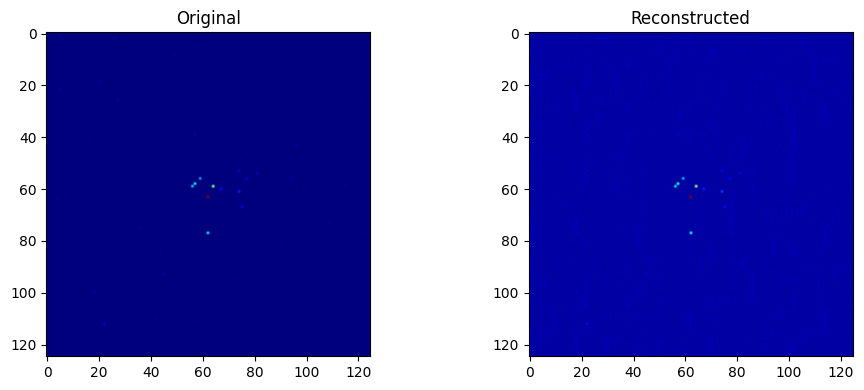

In [ ]:
model.eval()
with torch.no_grad():
    X, mask = next(iter(loader))
    X, mask = X.to(device), mask.to(device)
    X_hat, _ = model(X, mask)

import matplotlib.pyplot as plt

idx = 0
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(X[idx, 0].cpu(), cmap='jet')
axes[0].set_title("Original")
axes[1].imshow(X_hat[idx, 0].cpu(), cmap='jet')
axes[1].set_title("Reconstructed")
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), "sparse_autoencoder_2.pth")
print("\nModel saved → sparse_autoencoder.pth")


Model saved → sparse_autoencoder.pth


In [ ]:
# Save after training
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': total_loss,
}, "sparse_autoencoder_checkpoint_2.pth")
print("Model saved → sparse_autoencoder_checkpoint.pth")

Model saved → sparse_autoencoder_checkpoint.pth
